In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math


/tmp/ipykernel_24956/824730367.py:117: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([point[0], proj_point[0]], [point[1], proj_point[1]], 'k--', alpha=0.5,color=color)


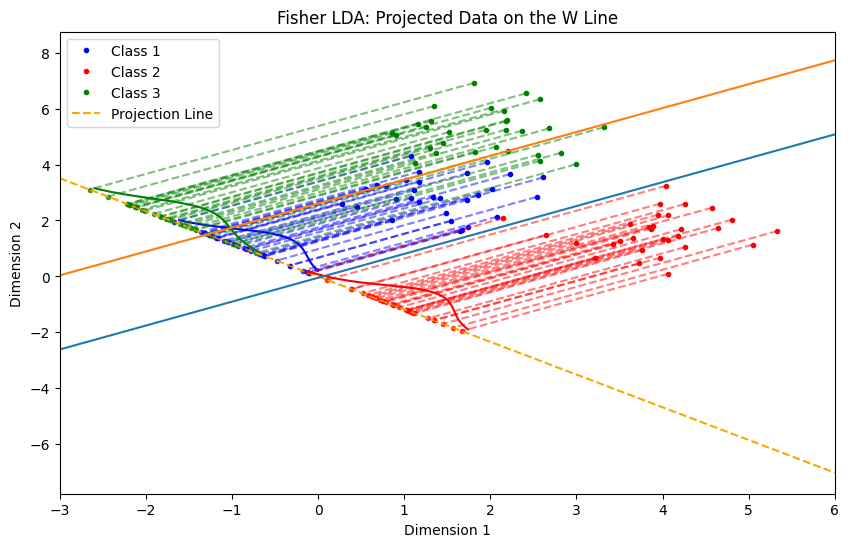

In [22]:

class FisherLDA:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.unique_labels = np.unique(labels)
        self.n_classes = len(self.unique_labels)
        self.means = []
        self.calculate_scatter_matrices()
        self.calculate_projection_vector()
        #self.calculate_class_parameters()

    def calculate_scatter_matrices(self):
        # Compute class means and overall mean
        self.class_means = [self.data[self.labels == cls].mean(axis=0) for cls in self.unique_labels]
        self.overall_mean = self.data.mean(axis=0)

        # Calculate the within-class scatter matrix
        SW = np.zeros((2, 2))
        for cls in self.unique_labels:
            class_data = self.data[self.labels == cls]
            class_scatter = np.cov(class_data.T)
            SW += class_scatter

        # Calculate the between-class scatter matrix
        SB = np.zeros((2, 2))
        for cls, class_mean in zip(self.unique_labels, self.class_means):
            class_data = self.data[self.labels == cls]
            n_class = len(class_data)
            mean_diff = (class_mean - self.overall_mean).reshape(-1, 1)
            SB += n_class * (mean_diff @ mean_diff.T)

        self.SW_inv = np.linalg.inv(SW)
        self.SB = SB

    def calculate_projection_vector(self):
        # Calculate the transformation matrix
        A = self.SW_inv @ self.SB

        # Get the eigenvalues and eigenvectors
        eigen_values, eigen_vectors = np.linalg.eig(A)

        # Select the eigenvector with the highest eigenvalue
        self.best_eigenvector = eigen_vectors[:, np.argmax(eigen_values)]

    def project(self, data):
        return data @ self.best_eigenvector


# Example use of the FisherLDA class with multi-class data
np.random.seed(42)

# Generate multi-class dataset
class1 = np.random.multivariate_normal((1.5, 3), [[0.5, 0], [0, 0.5]], 30)
class2 = np.random.multivariate_normal((4, 1.5), [[0.5, 0], [0, 0.5]], 30)
class3 = np.random.multivariate_normal((2, 5), [[0.5, 0], [0, 0.5]], 30)

data = np.vstack([class1, class2, class3])
labels = np.array([0] * 30 + [1] * 30 + [2] * 30)

# Initialize Fisher LDA
fisher_lda = FisherLDA(data, labels)

# Create a dictionary with class-wise data
data_by_class = {0: class1, 1: class2, 2: class3}


# Classify with the Fisher LDA projection
projected_data = fisher_lda.project(data)

# Visualize the original data, projection line, and projected data on the W line
plt.figure(figsize=(10, 6))
plt.gca().set_xlim(-3,6)
plt.plot(class1[:, 0], class1[:, 1], 'b.', label='Class 1')
plt.plot(class2[:, 0], class2[:, 1], 'r.', label='Class 2')
plt.plot(class3[:, 0], class3[:, 1], 'g.', label='Class 3')

# Plot the projection line
x_vals = np.array(plt.gca().get_xlim())
y_vals = (x_vals * fisher_lda.best_eigenvector[1] / fisher_lda.best_eigenvector[0])
plt.plot(x_vals, y_vals, '--', color='orange', label='Projection Line')


def calculate_angle(x1, y1, x2, y2):
    # Calculate the angle using arctan2
    angle_radians = math.atan2(y2 - y1, x2 - x1)
    # Convert radians to degrees
    angle_degrees = math.degrees(angle_radians)
    # Ensure the angle is between 0 and 360 degrees
    angle_degrees = (angle_degrees + 360) % 360
    return angle_degrees

# Example points
x1 = x_vals[0]
y1 = y_vals[0]
x2 = x_vals[1]
y2 = y_vals[1]

angle = calculate_angle(x1, y1, x2, y2)

MUX = []

def rotate_point(x, y, angle):
    # Convert angle from degrees to radians
    angle_rad = math.radians(angle)
    # Apply rotation formulas
    x_rotated = x * math.cos(angle_rad) - y * math.sin(angle_rad)
    y_rotated = x * math.sin(angle_rad) + y * math.cos(angle_rad)
    return x_rotated, y_rotated


# Project the original data onto the W line and plot with different colors
for cls, color in zip([class1, class2, class3], ['blue', 'red', 'green']):
    projected_class = fisher_lda.project(cls)
    
    for point, projection in zip(cls, projected_class):
        proj_point = projection * fisher_lda.best_eigenvector  # Point on W
        plt.plot([point[0], proj_point[0]], [point[1], proj_point[1]], 'k--', alpha=0.5,color=color)
        plt.scatter(proj_point[0], proj_point[1], color=color, s=9, alpha=0.7)

    projection = projected_class
    mu_proj_a, sigma_proj_a = norm.fit(projection)

    # Plot Gaussian distributions on the projection line
    x_gauss = np.linspace(projection.min(), projection.max(), 1000)
    y_gauss_a = norm.pdf(x_gauss, mu_proj_a, sigma_proj_a)

    rotated_x_gauss_a = []
    rotated_y_gauss_a = []

    for x, y in zip(x_gauss, y_gauss_a):
        rotated_x, rotated_y = rotate_point(x, y, angle)
        rotated_x_gauss_a.append(rotated_x)
        rotated_y_gauss_a.append(rotated_y)

    plt.plot(rotated_x_gauss_a, rotated_y_gauss_a, c=color)

    MUX.append(mu_proj_a)


MUX1, MUY1 = rotate_point((MUX[0]+MUX[1])/2, -10 , angle)
MUX2, MUY2 = rotate_point((MUX[0]+MUX[1])/2, +10, angle)
plt.plot([MUX1, MUX2], [MUY1, MUY2])

MUX1, MUY1 = rotate_point((MUX[0]+MUX[2])/2, -10 , angle)
MUX2, MUY2 = rotate_point((MUX[0]+MUX[2])/2, +10, angle)
plt.plot([MUX1, MUX2], [MUY1, MUY2])


plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Fisher LDA: Projected Data on the W Line')
plt.legend()
plt.show()

